In [1]:
import os.path
import shutil
import random
import itertools


import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, Flatten, BatchNormalization, Conv2D, MaxPool2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix

%matplotlib inline

2022-11-28 20:18:05.148127: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE3 SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-28 20:18:05.277421: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-11-28 20:18:06.095886: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.8'; dlerror: libnvinfer.so.8: cannot open shared object file: No such file or directory
2022-11-28 20:18:06.095980: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.8'; dlerror: libnvinfer_plugin.so.8: cannot open shared object

In [14]:
from consts import DATA_DIR
DATA_DIR

'/home/eddy/DataHDD-1/Seafile/Datasets/game-screenshots'

In [3]:
physical_devices = tf.config.experimental.list_physical_devices("GPU")
print(physical_devices)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


2022-11-28 20:18:11.645812: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-28 20:18:11.732306: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-28 20:18:11.732521: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


In [4]:
tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [15]:
# Copy dataset from original directory and format it into the correct structure
shutil.copytree(os.path.abspath(os.path.join(DATA_DIR, "original")), os.path.abspath(os.path.join(DATA_DIR, "formatted")))

'/home/eddy/DataHDD-1/Seafile/Datasets/game-screenshots/formatted'

In [16]:
DATA_DIR = os.path.join(DATA_DIR, "formatted")

TRAIN_DIR = os.path.join(DATA_DIR, "train")
TEST_DIR = os.path.join(DATA_DIR, "test")
VALID_DIR = os.path.join(DATA_DIR, "valid")

TRAIN_DIR_PIXEL = os.path.join(TRAIN_DIR, "pixel")
TRAIN_DIR_OTHER = os.path.join(TRAIN_DIR, "other")
TEST_DIR_PIXEL = os.path.join(TEST_DIR, "pixel")
TEST_DIR_OTHER = os.path.join(TEST_DIR, "other")
VALID_DIR_PIXEL = os.path.join(VALID_DIR, "pixel")
VALID_DIR_OTHER = os.path.join(VALID_DIR, "other")

In [17]:
os.mkdir(TRAIN_DIR)
os.mkdir(TEST_DIR)
os.mkdir(VALID_DIR)

os.mkdir(TRAIN_DIR_PIXEL)
os.mkdir(TRAIN_DIR_OTHER)
os.mkdir(TEST_DIR_PIXEL)
os.mkdir(TEST_DIR_OTHER)
os.mkdir(VALID_DIR_PIXEL)
os.mkdir(VALID_DIR_OTHER)

for c in random.sample(os.listdir(os.path.join(DATA_DIR, "pixel")), 280):
    shutil.move(os.path.join(DATA_DIR, "pixel", c), os.path.join(TRAIN_DIR_PIXEL, c))

for c in random.sample(os.listdir(os.path.join(DATA_DIR, "other")), 280):
    shutil.move(os.path.join(DATA_DIR, "other", c), os.path.join(TRAIN_DIR_OTHER, c))

for c in random.sample(os.listdir(os.path.join(DATA_DIR, "pixel")), 80):
    shutil.move(os.path.join(DATA_DIR, "pixel", c), os.path.join(VALID_DIR_PIXEL, c))

for c in random.sample(os.listdir(os.path.join(DATA_DIR, "other")), 80):
    shutil.move(os.path.join(DATA_DIR, "other", c), os.path.join(VALID_DIR_OTHER, c))

for c in random.sample(os.listdir(os.path.join(DATA_DIR, "pixel")), 40):
    shutil.move(os.path.join(DATA_DIR, "pixel", c), os.path.join(TEST_DIR_PIXEL, c))

for c in random.sample(os.listdir(os.path.join(DATA_DIR, "other")), 40):
    shutil.move(os.path.join(DATA_DIR, "other", c), os.path.join(TEST_DIR_OTHER, c))

shutil.rmtree(os.path.join(DATA_DIR, "pixel"))
shutil.rmtree(os.path.join(DATA_DIR, "other"))

In [26]:
# Cut images in four parts to increase the training images
from image_slicer import slice

for img in os.listdir(TRAIN_DIR_PIXEL):
    slice(os.path.join(TRAIN_DIR_PIXEL, img), 4)

for img in os.listdir(TRAIN_DIR_OTHER):
    slice(os.path.join(TRAIN_DIR_OTHER, img), 4)

for img in os.listdir(VALID_DIR_PIXEL):
    slice(os.path.join(VALID_DIR_PIXEL, img), 4)

for img in os.listdir(VALID_DIR_OTHER):
    slice(os.path.join(VALID_DIR_OTHER, img), 4)

for img in os.listdir(TEST_DIR_PIXEL):
    slice(os.path.join(TEST_DIR_PIXEL, img), 4)

for img in os.listdir(TEST_DIR_OTHER):
    slice(os.path.join(TEST_DIR_OTHER, img), 4)

In [19]:
train_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input)\
    .flow_from_directory(directory=TRAIN_DIR, target_size=(224, 224), classes=["pixel", "other"], batch_size=32)
valid_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input)\
    .flow_from_directory(directory=VALID_DIR, target_size=(224, 224), classes=["pixel", "other"], batch_size=32)
test_branches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input)\
    .flow_from_directory(directory=TEST_DIR, target_size=(224, 224), classes=["pixel", "other"], batch_size=32)

Found 560 images belonging to 2 classes.
Found 160 images belonging to 2 classes.
Found 80 images belonging to 2 classes.


In [28]:
imgs, labels = next(train_batches)

In [29]:
def plot_images(images_arr):
    fig, axes = plt.subplots(1, 10, figsize=(20, 20))
    axes = axes.flatten()
    for img, ax in zip(images_arr, axes):
        ax.imshow(img)
        ax.axis("off")
    plt.tight_layout()
    plt.show()

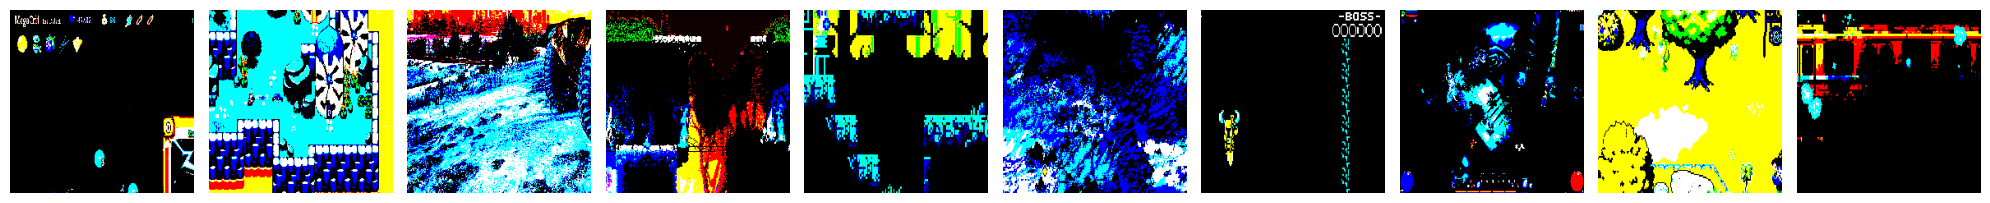

[[0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]]


In [30]:
plot_images(imgs)
print(labels)

In [82]:
model = Sequential([
    Conv2D(filters=32, kernel_size=(17, 17), activation="relu", padding="same", input_shape=(224, 224, 3)),
    MaxPool2D(pool_size=(2, 2), strides=2),
    Conv2D(filters=64, kernel_size=(7, 7), activation="relu", padding="same"),
    MaxPool2D(pool_size=(2, 2), strides=2),
    Conv2D(filters=128, kernel_size=(5, 5), activation="relu", padding="same"),
    Flatten(),
    Dense(units=2, activation="softmax")
])

In [83]:
model.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_39 (Conv2D)          (None, 224, 224, 32)      27776     
                                                                 
 max_pooling2d_26 (MaxPoolin  (None, 112, 112, 32)     0         
 g2D)                                                            
                                                                 
 conv2d_40 (Conv2D)          (None, 112, 112, 64)      100416    
                                                                 
 max_pooling2d_27 (MaxPoolin  (None, 56, 56, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_41 (Conv2D)          (None, 56, 56, 128)       204928    
                                                                 
 flatten_12 (Flatten)        (None, 401408)          

In [84]:
model.compile(optimizer=Adam(learning_rate=0.0001), loss="categorical_crossentropy", metrics=["accuracy"])

In [85]:
model.fit(x=train_batches, validation_data=valid_batches, epochs=10, verbose=2)

Epoch 1/10
18/18 - 12s - loss: 32.1231 - accuracy: 0.4911 - val_loss: 1.6420 - val_accuracy: 0.5000 - 12s/epoch - 688ms/step
Epoch 2/10
18/18 - 11s - loss: 1.0402 - accuracy: 0.6196 - val_loss: 1.2080 - val_accuracy: 0.5437 - 11s/epoch - 585ms/step
Epoch 3/10
18/18 - 10s - loss: 0.4820 - accuracy: 0.7643 - val_loss: 0.7312 - val_accuracy: 0.6125 - 10s/epoch - 575ms/step
Epoch 4/10
18/18 - 12s - loss: 0.3013 - accuracy: 0.8911 - val_loss: 0.7096 - val_accuracy: 0.6812 - 12s/epoch - 639ms/step
Epoch 5/10
18/18 - 11s - loss: 0.1703 - accuracy: 0.9429 - val_loss: 0.6974 - val_accuracy: 0.6750 - 11s/epoch - 630ms/step
Epoch 6/10
18/18 - 11s - loss: 0.1082 - accuracy: 0.9696 - val_loss: 0.7142 - val_accuracy: 0.7063 - 11s/epoch - 597ms/step
Epoch 7/10
18/18 - 11s - loss: 0.0689 - accuracy: 0.9804 - val_loss: 0.8199 - val_accuracy: 0.7125 - 11s/epoch - 590ms/step
Epoch 8/10
18/18 - 11s - loss: 0.0421 - accuracy: 0.9911 - val_loss: 0.8791 - val_accuracy: 0.6625 - 11s/epoch - 588ms/step
Epoch 9

In [ ]:
model.save("models/v9-noslice-biggerkernels3")

In [86]:
from tensorflow.keras.models import load_model
model = load_model("models/v8-noslice-biggerkernels2")

In [87]:
def plot_confusion_matrix(cm, classes, normalize=False, title="Confusion matrix", cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation="nearest", cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print("Confusion matrix, without normalization")
    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j], horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel("True label")
    plt.xlabel("Predicted label")

In [88]:
predictions = model.predict(x=test_branches, verbose=0)

In [89]:
np.round(predictions)

array([[1., 0.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [1., 0.

In [90]:
cm = confusion_matrix(y_true=test_branches.classes, y_pred=np.argmax(predictions, axis=-1))

In [91]:
test_branches.class_indices

{'pixel': 0, 'other': 1}

Confusion matrix, without normalization
[[25 15]
 [14 26]]


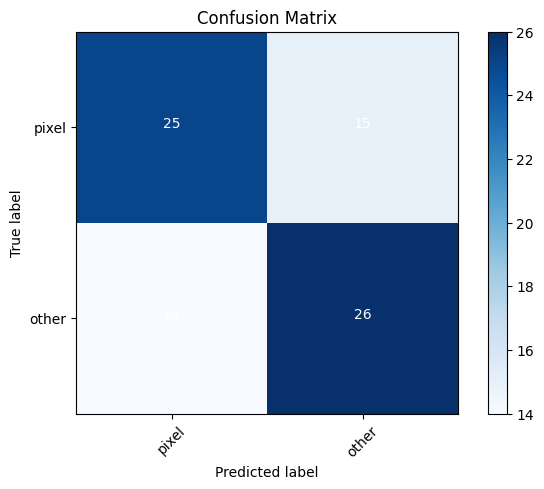

In [92]:
cm_plot_labels = ["pixel", "other"]
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title="Confusion Matrix")